in the Integral Riccati:

$$ \psi = I_\alpha (\lambda \psi^2 + \mu \psi + \nu) = I_\alpha(g)$$

(if the initial condition $I_{1-\alpha} \psi(0) = 0$.) where 

$$g = \lambda \psi^2 + \mu \psi + \nu$$

We will compute $I_\alpha(\lambda \psi^2 + \mu \psi + \nu)$ throught the left-rectangles. We will use $\psi_t$ as 
a function of the neural network. 

We can use $\psi_t := x^\alpha N(x)$ 

In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
T = 1/252
alpha = 0.64
lambd = 0.045
mu = -64.938
nu = 444

# Best results given with:
#T = 1/252
#alpha = 0.64
#lambd = 0.045
#mu = -64.938
#nu = 444


In [3]:
N = nn.Sequential(nn.Linear(1, 15), nn.Sigmoid(),nn.Linear(15,1, bias=False))


Psi_t = lambda x: x**alpha * N(x)  # Trial solution

### We remind the fractional R-L integral is defined as:

$$I_\alpha g(t) = \frac{1}{\Gamma(\alpha)}\int_0^t (t-s)^{\alpha -1} g(s) ds $$

In [4]:
n_points = 20
def f(x):
    return x**2

x_train = f(np.linspace(0, T, n_points)[:, None])
x = torch.Tensor(x_train)
x.requires_grad = True
# delta_x = T/(n_points-1)

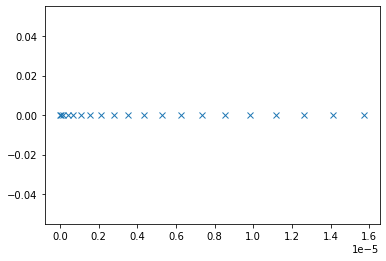

In [5]:
fix, ax = plt.subplots()
ax.plot(x_train, np.zeros(n_points), "x")

In [6]:
def g(x):
    result = lambd*Psi_t(x)**2+mu*Psi_t(x)+nu
    return result

def g_ia(s,t):
    return (t-s)**(alpha-1)*g(s)

In [7]:
def loss(x):
    
    outputs = Psi_t(x)
    
    
    # Notice that the below is indipendent by how x is distributed (could be a different distribution of points)
    integrals_vector = x.double() # just copying x, but then we will change it, only to have something with same dimen.
    for t in range(n_points):
        tot_sum = 0
        for s in range(n_points):
            if s<t:  # we do not consider s = t because of the singularity. We take only left rectangles.
                ss = x[s]
                tt = x[t]
                delta_x_2 = x[s+1]-x[s]
                tot_sum += g_ia(ss,tt)*delta_x_2   # To remove delta_x_2 and leave delta_x below
        integrals_vector[t][0] = tot_sum
        
    #integrals_vector *= delta_x
    integrals_vector *= 1/math.gamma(alpha)

    final_loss = torch.mean((outputs - integrals_vector)**2)
    
    print('loss is', final_loss)

    return final_loss

In [8]:
optimizer = torch.optim.LBFGS(N.parameters(), lr=0.1)

def closure():

    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    
    return l

In [9]:
# Here train the neural network
for i in range(2):
    optimizer.step(closure)

loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss is tensor(0.0384, dtype=torch

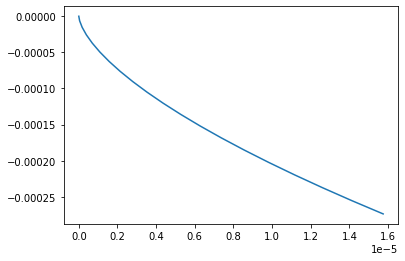

In [10]:
fig, ax = plt.subplots()
xx = x.tolist()
yy = Psi_t(x)[:,0].tolist()
ax.plot(xx, yy)

# Comparing results with Euler

In [11]:
# error measures
epsilon = 0.01
theta = 0.9

r_max = 105

def returns_all_the_first_r_max_coefficients_as_list_2():
    ''' Run this function. This returns the list of coefficients. Up to a_k where 
        k = r_max. '''
    
    coefficients = [np.nan]*(r_max+1)

    a0 = 0 
    a1 = nu/math.gamma(alpha+1)
    coefficients[0] = a0
    coefficients[1] = a1
    
    
    def recursive_convol_coefficients(list_of_coefficients, k):
        ''' return a*_k^2  given the first k-1 a_m coefficients. 
        k is the coefficient a^_k^2 to be returned'''
        if k==1:
            return 0
        else: 
            sum = 0
            for l in range(1,k):
                a_l = list_of_coefficients[l]
                a_k_l = list_of_coefficients[k-l]
                sum += a_l*a_k_l
            return sum
    
    
    def recursive_coefficients(list_of_coefficients, n):
        ''' Given the convoluted coefficient a_k_star_quadro, 
        Given also n, the coefficient a_n to be returned... Note that n = k+1 !!! 
        returns a_k'''
        k = n-1 # n-1 = k
        a_k_star_quadro = recursive_convol_coefficients(list_of_coefficients, k) 
        a_k = list_of_coefficients[k]  
        a_n = (lambd*a_k_star_quadro + mu*a_k)*math.gamma(alpha*k + 1)/math.gamma(alpha*k + alpha + 1)
    
        return a_n

    for i in range(2, r_max+1):
        coefficients[i] = recursive_coefficients( coefficients, i)
        
    return coefficients

coeff = returns_all_the_first_r_max_coefficients_as_list_2()

coeff_df = pd.DataFrame(coeff)

a_r_max = coeff[-1]
a_primo_r_max = a_r_max*math.gamma(alpha*r_max+1)/(math.gamma(alpha*r_max-alpha+1)*(alpha*r_max+1-alpha))

R_estimate = abs(a_primo_r_max)**(-1/(alpha*r_max))

r_0 = math.log(epsilon*(1-theta))/alpha/math.log(theta)-1
r_0 = int(np.round(r_0)+1)

slicing = slice(0,r_0)

coeff_truncated = coeff[slicing]

def poly(lst, x):   
    ''' Evaluate the polynomial with coefficients lst= [a0,a1,a2,...] in x
    Pol: a0 + a1*x**alpha + a2*x**(2*alpha) + .... '''
    n, tmp = 0, 0
    for a in lst:
        tmp = tmp + (a * (x**(n*alpha)))
        n += 1

    return tmp

def computing_psi_n(n):
    ''' Just Give n. This function makes use of the parameters. Then also of the list "coeff_truncated" 
    '''
    
    disc_times = [k*T/n for k in range(0,n+1)]
    
    theta = 0.9
    #theta = theta_n(n) # Only In This Example, Because The Theta fixed at the beginning would go out otherwise!
    
    
    
    k_0 = math.floor(R_estimate*theta*n/T)  ### Up to t_k_0 we will use truncated series. Then Euler Schema
    
    if k_0 >= len(disc_times):
        t_k_0 = "Doesn't exist t_k_0"
    else: 
        t_k_0 = disc_times[k_0]
    
    values_assumed_in_disc_times = [np.nan]*(n+1)
    

    
    
    ### Here We Evaluate The Truncated Series!
    
    if k_0 <= len(disc_times):
        for k in range(0,k_0+1):
            values_assumed_in_disc_times[k] = poly(coeff_truncated, disc_times[k])
    else:
        for k in range(0,n):
            values_assumed_in_disc_times[k] = poly(coeff_truncated, disc_times[k])
    
    
    
    
    ### Here Instead We Use The Euler Scheme
    def compute_c_i(alpha, l):
        if l == 0:
            return 1
        else: 
            return (l+1)**alpha - l**alpha
    
    
    
    for k in range(k_0+1, n+1):
        factor_1 = 1/math.gamma(alpha + 1)*(T/n)**alpha
        addend_2 = nu*k**alpha 
        addend_3 = 0
        for l in range(1,k):
            psi_n_t_l = values_assumed_in_disc_times[l]
            addend_3 += compute_c_i(alpha, k-l-1)*psi_n_t_l*(lambd*psi_n_t_l + mu)
        
        factor_2 = addend_2 + addend_3
        
        result = factor_1*factor_2
        
        values_assumed_in_disc_times[k] = result
            
    
    print("t_k0=", t_k_0)
    
    #return disc_times, values_assumed_in_disc_times
    return pd.DataFrame({"time": disc_times, "value": values_assumed_in_disc_times}), t_k_0

In [12]:
R_estimate

0.005939274862561235

In [13]:
T

0.003968253968253968

In [14]:
r_0

102

In [15]:
# Problem is that if we set r_max too high, then the coefficients go to infinity. 
# coeff

In [16]:
comparison = computing_psi_n(1028)

t_k0= Doesn't exist t_k_0


In [17]:
results_euler_scheme = comparison[0]

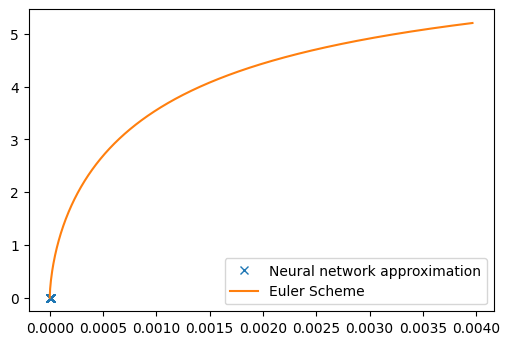

In [18]:
fig, ax = plt.subplots(dpi=100)
xx = x.tolist()
yy = Psi_t(x)[:,0].tolist()
# yt = Psi_real(x).tolist()
ax.plot(xx, yy, "x",  label='Neural network approximation')
ax.plot(results_euler_scheme.time, results_euler_scheme.value,  label='Euler Scheme')

ax.legend(loc="best")

if type(comparison[1]) == type(2.0):
    ax.axvline(x = comparison[1], linewidth=1, color='r')